In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv


# Import libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

import re

# Load Data

In [3]:
df = pd.read_csv('/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv')

In [4]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


# Data Inspection

In [5]:
df.shape

(1956, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


In [7]:
df.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
VIDEO_NAME      0
CLASS           0
dtype: int64

In [8]:
df.duplicated().sum()

3

# Exploratory Data Analysis (EDA)

## Spam vs Real Analysis

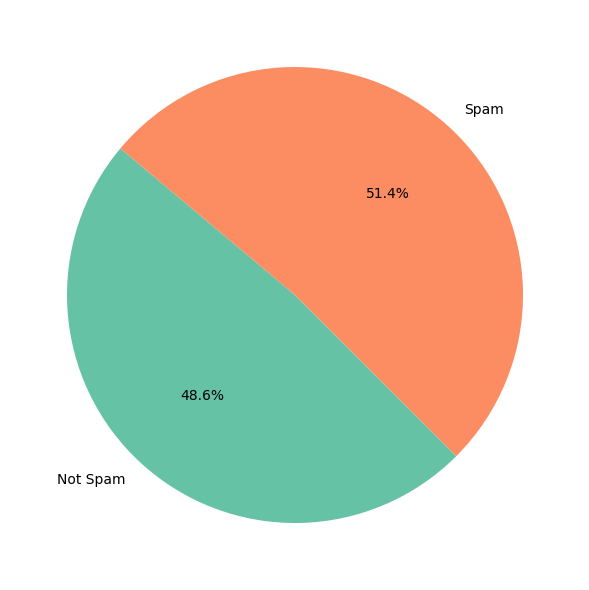

In [9]:
#pie chart of spam vs real comments
spam_counts = df['CLASS'].value_counts().sort_index()

palette = sns.color_palette("Set2", n_colors=len(spam_counts))
fig = plt.figure(figsize=(10, 6))
plt.pie(spam_counts, autopct='%1.1f%%', startangle=140, colors=palette, labels=["Not Spam", "Spam"])
plt.tight_layout()
plt.show()

## What videos are the most commented on?

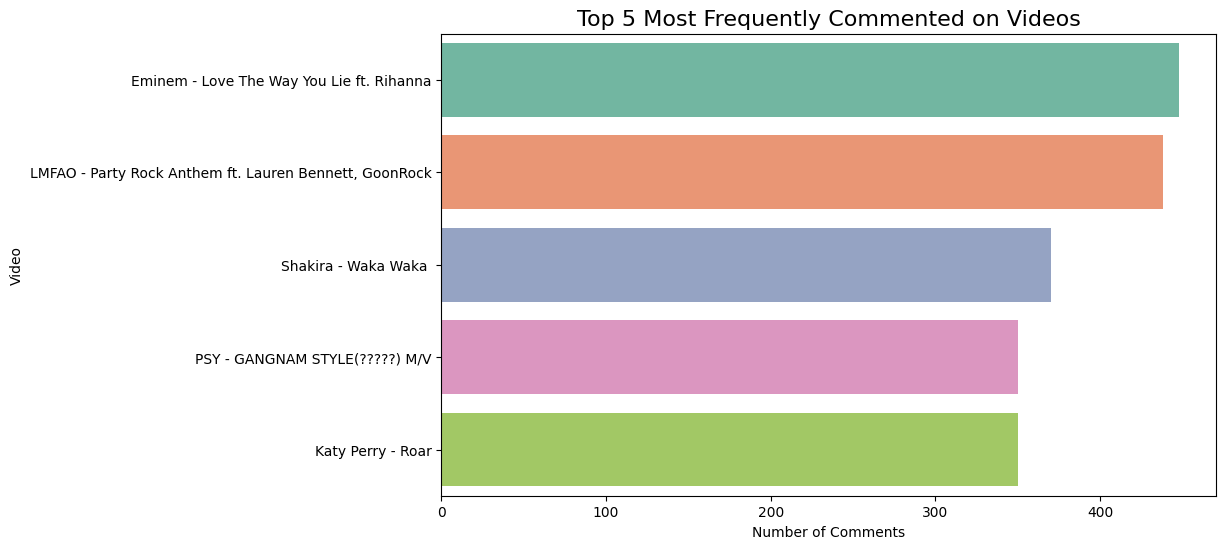

In [10]:
#plot for most commented on videos
plt.figure(figsize=(10, 6))
sns.barplot(x=df['VIDEO_NAME'].value_counts().head(5).values, 
            y=df['VIDEO_NAME'].value_counts().head(5).index, palette='Set2')
plt.title('Top 5 Most Frequently Commented on Videos', fontsize=16)
plt.xlabel('Number of Comments')
plt.ylabel('Video')
plt.show()

## What time of the day are most comments made? What time of the day are most spam comments made?

In [11]:
#function to remove fractional seconds from comment date 
def clean_datetime(x):
    if pd.isna(x):  
        return x
    return re.sub(r'\.\d+', '', str(x)) 

#apply function to the date column
df['comment_date_clean'] = df['DATE'].apply(clean_datetime)
#convert columns to datetime
df['DATE'] = pd.to_datetime(df['comment_date_clean'], errors='coerce')
#drop intermediate column
df = df.drop(columns=['comment_date_clean'])

In [12]:
#function to assign time of the day to comment date
def categorize_time_of_day(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 23:
        return 'Evening'
    else:
        return 'Late Night'

#extract hour from the comment date and assigne time of day
df['hour'] = df['DATE'].dt.hour
df['time_of_day'] = df['hour'].apply(lambda x: categorize_time_of_day(x) if pd.notnull(x) else 'Unknown')

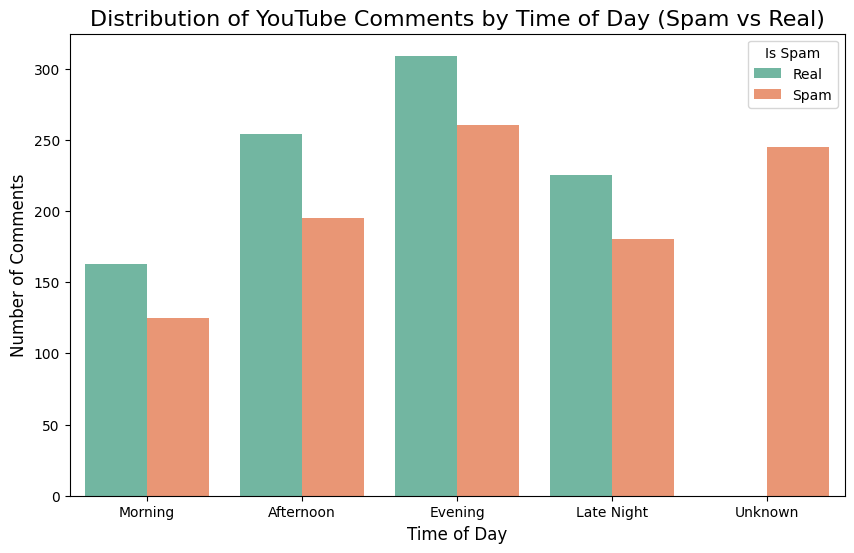

In [13]:
#create plot for time of day feature
plt.figure(figsize=(10, 6))

sns.countplot(data=df, x='time_of_day', hue='CLASS', palette='Set2')

plt.title('Distribution of YouTube Comments by Time of Day (Spam vs Real)', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)

plt.legend(title='Is Spam', loc='upper right', labels=['Real', 'Spam'])

plt.show()

## How long are the comments?

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

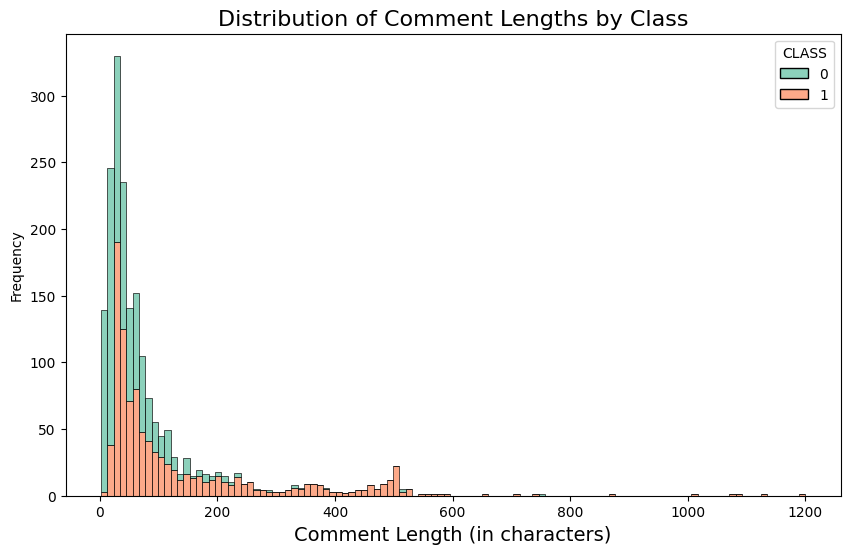

In [14]:
#create field for comment length
df['Comment Length'] = df['CONTENT'].apply(len)

#create plot for comment length feature
plt.figure(figsize=(10, 6))
sns.histplot(df, x='Comment Length', hue='CLASS', multiple='stack', palette='Set2')
plt.title('Distribution of Comment Lengths by Class', fontsize=16)
plt.xlabel('Comment Length (in characters)', fontsize=14)
plt.ylabel('Frequency')
plt.show()

## What is the lengh of users' names?

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

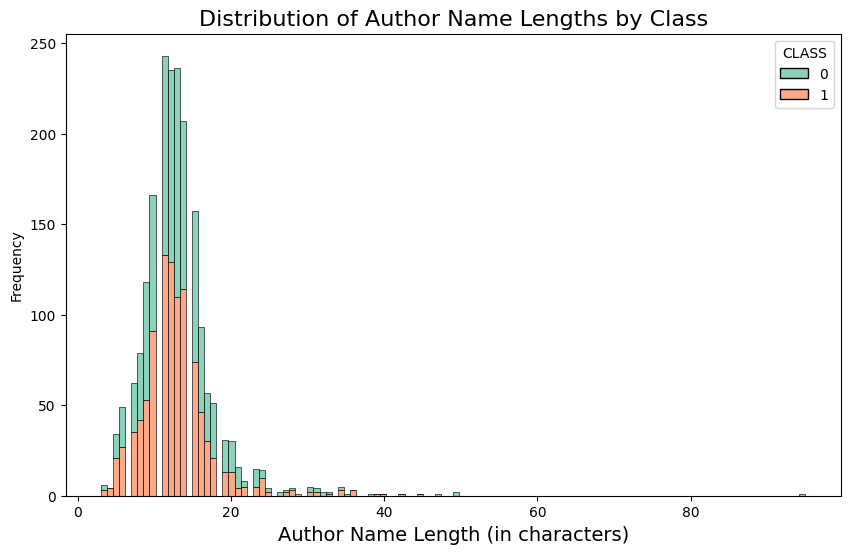

In [15]:
#create field for author name length
df['Author Length'] = df['AUTHOR'].apply(len)

#create plot for author length feature
plt.figure(figsize=(10, 6))
sns.histplot(df, x='Author Length', hue='CLASS', multiple='stack', palette='Set2')
plt.title('Distribution of Author Name Lengths by Class', fontsize=16)
plt.xlabel('Author Name Length (in characters)', fontsize=14)
plt.ylabel('Frequency')
plt.show()

# Drop Duplicates

In [16]:
df.drop_duplicates(inplace=True)

# Feature Selection

In [17]:
#create training date to be vectorized
df['training_data'] = df['VIDEO_NAME'] + ' ' + df['AUTHOR'] + ' ' + df['time_of_day'] + ' ' + df['CONTENT']

#assign training data and labels
X = df['training_data']
y = df['CLASS']

#vectorize training data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

#split data into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression

In [18]:
#create logistic regression pipeline
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

#train the model
pipeline_lr.fit(X_train, y_train)

#evaluate the model
y_pred = pipeline_lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       170
           1       0.98      0.92      0.95       221

    accuracy                           0.94       391
   macro avg       0.94      0.95      0.94       391
weighted avg       0.95      0.94      0.94       391



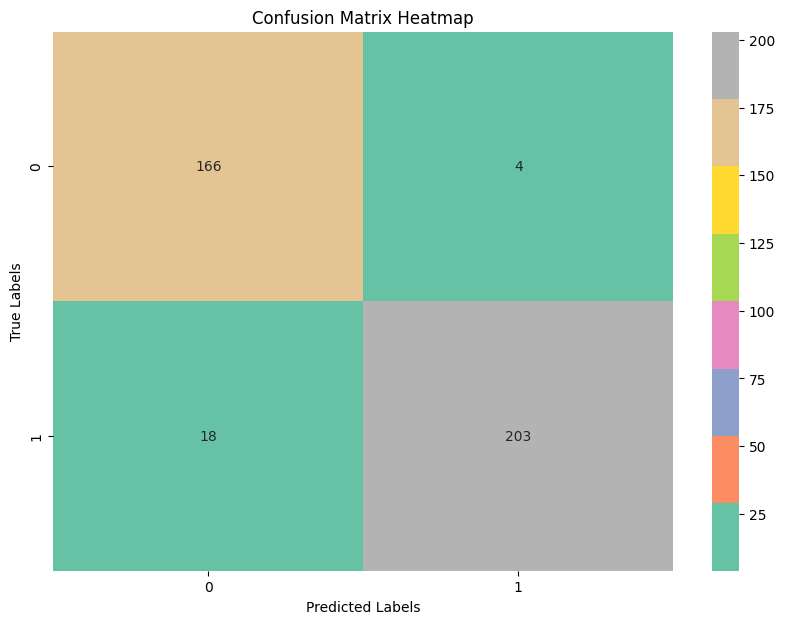

In [19]:
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Set2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# SVM

In [20]:
#create svm pipeline
pipeline_SVM = Pipeline(steps=[
    ('classifier', LinearSVC())
])

#train the model
pipeline_SVM.fit(X_train, y_train)

#evaluate the model
y_pred = pipeline_SVM.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       170
           1       0.99      0.94      0.96       221

    accuracy                           0.96       391
   macro avg       0.96      0.96      0.96       391
weighted avg       0.96      0.96      0.96       391



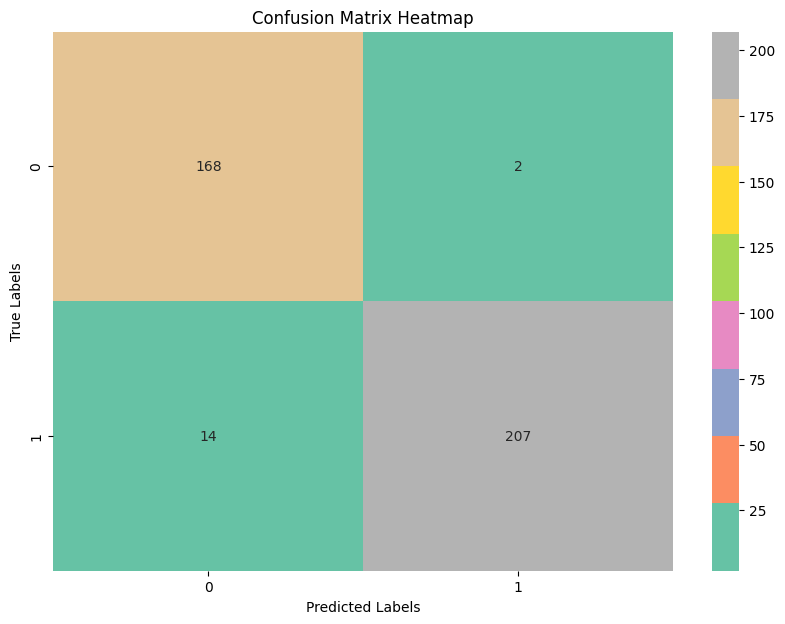

In [21]:
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Set2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# XGBoost

In [22]:
#create xgb pipeline
pipeline_xgb = Pipeline(steps=[
    ('classifier', XGBClassifier())
])

#train the model
pipeline_xgb.fit(X_train, y_train)

#evaluate the model
y_pred = pipeline_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       170
           1       0.99      0.93      0.96       221

    accuracy                           0.95       391
   macro avg       0.95      0.96      0.95       391
weighted avg       0.96      0.95      0.95       391



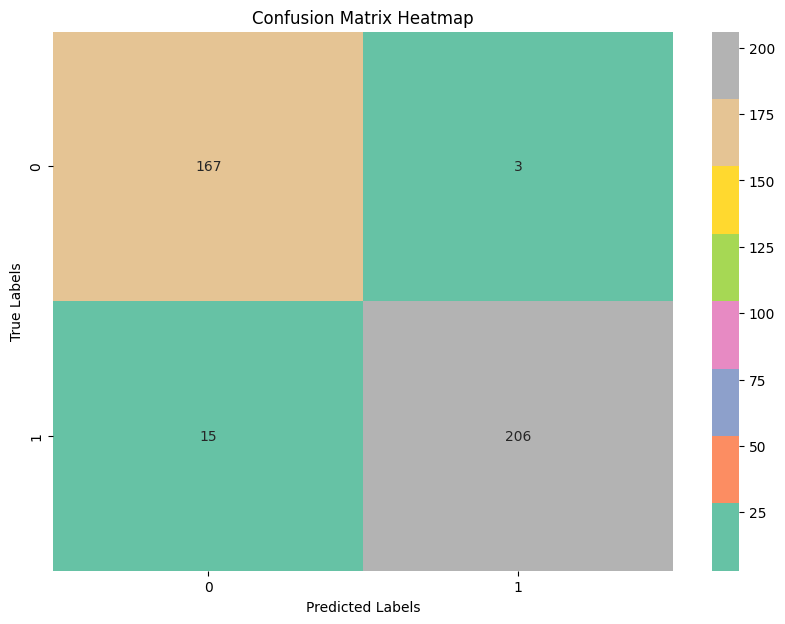

In [23]:
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Set2')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()